In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import scipy.linalg as LA
from scipy.signal import lsim, dlsim
from scipy.integrate import solve_ivp
import opentorsion as ot
import cvxpy as cp

In [2]:
plt.style.use(['science', 'ieee'])
plt.rcParams["figure.figsize"] = (6,4)

# The propulsion system

Firstly, the propulsion system presented in [Inverse ice-induced moment determination on the propeller of an ice-going vessel](https://www.sciencedirect.com/science/article/pii/S0165232X14002274) is modelled using the openTorsion library. Parameters for the propulsion system are found from [here](https://journals.sagepub.com/doi/full/10.1177/14759217211004232).

In [3]:
def propulsion_system():
    J1 = 1.347e4 # propeller
    J3 = 5.590e2
    J5 = 5.120e2
    J7 = 4.870e2
    J9 = 1.410e2
    J11 = 1.740e2
    J13 = 4.415e3 # motor
    
    k2 = 5.88e7
    k4 = 5.95e7
    k6 = 1.12e8
    k8 = 6.93e8
    k10 = 5.09e8
    k12 = 1.43e8
    damping = 180 # damping in steel_shafts
    
    shafts, disks = [], []
    disks.append(ot.Disk(0, I=J1))
    shafts.append(ot.Shaft(0, 1, None, None, k=k2, I=0, c=damping))
    disks.append(ot.Disk(1, I=J3))
    shafts.append(ot.Shaft(1, 2, None, None, k=k4, I=0, c=damping))
    disks.append(ot.Disk(2, I=J5))
    shafts.append(ot.Shaft(2, 3, None, None, k=k6, I=0, c=damping))
    disks.append(ot.Disk(3, I=J7))
    shafts.append(ot.Shaft(3, 4, None, None, k=k8, I=0, c=damping))
    disks.append(ot.Disk(4, I=J9))
    shafts.append(ot.Shaft(4, 5, None, None, k=k10, I=0, c=damping))
    disks.append(ot.Disk(5, I=J11))
    shafts.append(ot.Shaft(5, 6, None, None, k=k12, I=0, c=damping))
    disks.append(ot.Disk(6, I=J13))
    
    assembly = ot.Assembly(shafts, disk_elements=disks)
    _, f, _ = assembly.modal_analysis()
    print("Eigenfrequencies: ", f.round(2))

    return assembly

In [4]:
def state_matrices(assembly):
    """
    Create state-space matrices A and B of an openTorsion assembly.

    Parameters:
    assembly : openTorsion assembly instance
        Mechanical drivetrain model.

    Returns:
    A : numpy.ndarray
        The state matrix
    B : numpy.ndarray
        The input matrix
    """
    M, C, K = assembly.M(), assembly.C(), assembly.K()  # Mass and stiffness matrices
    Z = np.zeros(M.shape)
    I = np.eye(M.shape[0])
    M_inv = LA.inv(M)

    A = np.vstack([np.hstack([Z, I]), np.hstack([-M_inv @ K, -M_inv @ C])])

    B = np.vstack([Z, M_inv])

    return A, B

In [5]:
def c2d(A,B,Ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time T_s.
    The function returns matrices A,B of the discrete-time system.
    """
    m, n = A.shape
    nb = B.shape[1]

    s = np.concatenate([A, B], axis=1)
    s = np.concatenate([s, np.zeros( (nb,n+nb) )], axis=0)
    S = LA.expm(s*Ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]
    
    return Ad, Bd

In [6]:
def X(k_values, ndof):
    """
    Used to transform the state-matrix to be compatible with shaft torque as a state.
    """
    rows = ndof-1
    cols = ndof
    if len(k_values) != rows:
        print("wrong amount of stiffness values / dofs")
        return
    
    X_up = np.zeros((rows, cols))
    X_down = np.eye(cols)
    Z_up = np.zeros(X_up.shape)
    Z_down = np.zeros(X_down.shape)
    
    for i in range(rows):
        X_up[i,i] = -k_values[i]
        X_up[i,i+1] = k_values[i]
    
    X_matrix = np.vstack([np.hstack([X_up, Z_up]), np.hstack([Z_down, X_down])])
    
    return X_matrix

The model is defined to have shaft torques and nodal rotational speeds as states. The state-space model is as follows (details in the "modified_state_matrix_2dof" notebook):

$$ \begin{bmatrix} \dot{\tau}_{1,2} \\ \vdots \\ \dot{\tau}_{n-1,n} \\ \ddot{\theta}_1 \\ \vdots \\  \ddot{\theta}_n \end{bmatrix}_{2n-1 \times 1} = \textbf{X}_{2n-1 \times 2n} \textbf{A}_{2n \times 2n} \textbf{X}^{-1}_{2n \times 2n-1} \begin{bmatrix} \tau_{1,2} \\ \vdots \\ \tau_{n-1,n} \\ \dot{\theta}_1 \\ \vdots \\ \dot{\theta}_n \end{bmatrix}_{2n-1 \times 1} + \textbf{X}_{2n-1 \times 2n} \textbf{B}_{2n-1 \times n} \begin{bmatrix} T \\ \vdots \\ 0 \end{bmatrix}_{n \times 1} $$

where $n$ is the number of degrees of freedom of the system, $\textbf{A}$ and $\textbf{B}$ are the state matrices and $T$ is load torque (in this case applied on node 0).

### Construction of the extended observability matrix and the impulse response matrix used in the data equation.

In [7]:
def O(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    A_power = np.copy(A)
    O = np.vstack((np.copy(C), C @ A))
    
    for k in range(n-2):
        A_power = A_power @ A
        O = np.vstack((O, C @ A_power))

    return O

In [8]:
def gamma(A, B, C, n):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    A_power = np.copy(A)
    Z = np.zeros((C @ B).shape)
    
    # first column
    gamma_column_first = np.vstack((
        Z,
        C @ B, 
        C @ A @ B
    ))
    for _ in range(n-3):
        A_power = A_power @ A
        gamma_column_first = np.vstack((gamma_column_first, C @ A_power @ B))

    # build complete matrix, column by column, from left to right
    gamma = np.copy(gamma_column_first)
    current_column = 1
    for _ in range(1, n):
        gamma_rows = Z
        
        # first add zero matrices
        for _ in range(current_column):
            gamma_rows = np.vstack((gamma_rows, Z))
        
        # then add the impulse responses
        A_power2 = np.copy(A)
        
        if current_column < (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B,
                C @ A @ B # these must not be added to the last and the second to last columns
            ))
            
        if current_column == (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B # this has to be added to the end of the second to last column
            ))
        
        for _ in range(n-current_column-3):
            A_power2 = A_power2 @ A
            gamma_rows = np.vstack((gamma_rows, C @ A_power2 @ B))

        # add column on the right hand side
        gamma = np.hstack((gamma, gamma_rows))
        current_column += 1
    
    return gamma

### The regularization matrix

The regularization matrix $L$ as presented in the paper of Ikonen et al. (Note: In the paper, the external load of the propulsion system model is described in changes of moment between consecutive timesteps. Perhaps an identity matrix should be used here?)

In [9]:
def L(input_shape):
    '''
    The regularization matrix L.

    Parameters:

    meas_shape : float
        Input vector shape used to determine L matrix shape.

    Returns:

    L : ndarray
        The regularization matrix
    '''
    I = np.eye(input_shape)
    L = -I + np.diag(np.ones(input_shape-1), 1)

    return I

### Convex optimization problem

Here a Tikhonov-regularized optimization problem is defined using measurements from the propulsion system model, the data equation matrix $\Gamma$ and the regularization matrix $L$. For the present case, an optimal regularization parameter $\lambda = 0.0512$ is defined using the L-curve plot in the paper of Ikonen et al.

The python package [CVXPY](https://www.cvxpy.org/) provides an interface for the solver ([SCS](https://www.cvxgrp.org/scs/) or [MOSEK](https://www.mosek.com/)), which is used to solve the Tikhonov-regularized optimization problem.

In [10]:
def convex_optimization_problem(meas, obsrv, gamm, regu, initial_state=None, lam=0.0512):
    '''
    Convex optimization methods using the cvxpy library.
    '''
    d = cp.Variable((gamm.shape[1], 1))
    
    if initial_state is None:
        x = np.zeros((obsrv.shape[1], 1))
    else:
        x = initial_state
        
    measurements = cp.Parameter(meas.shape)
    measurements.value = meas
    
    objective = cp.Minimize(cp.sum_squares(measurements - obsrv @ x - gamm @ d) + lam * cp.sum_squares(regu @ d))
    prob = cp.Problem(objective)
    
    prob.solve()

    return d.value

### Unit step response of the propulsion system

Here a unit step response is calculated for the propulsion system. The shaft torque between nodes 3 and 4 is plotted, as is in the paper of Ikonen et al.

In [11]:
# Initialize an assembly instance and construct the state-space model
assembly = propulsion_system()
ndof = assembly.dofs
A, B = state_matrices(assembly)
C = np.eye(B.shape[0])
D = np.zeros(B.shape)

# The state-space model is modified to have shaft torque as a state (instead of nodal angles).
k_list = [5.88e7, 5.95e7, 1.12e8, 6.93e8, 5.09e8, 1.43e8]
trans = X(k_list, ndof)
trans_inv = trans.T @ np.linalg.inv(trans @ trans.T)
A_transformed = trans @ A @ trans_inv
B_transformed = trans @ B
C_transformed = np.eye(B_transformed.shape[0])
D_transformed = np.zeros(B_transformed.shape)
A_transformed = A_transformed.astype('d')
B_transformed = B_transformed.astype('d')
C_transformed = C_transformed.astype('d')
D_transformed = D_transformed.astype('d')

Eigenfrequencies:  [  0.     0.    11.41  11.41  48.93  48.93  78.82  78.82 115.27 115.27
 268.61 268.61 522.81 522.81]


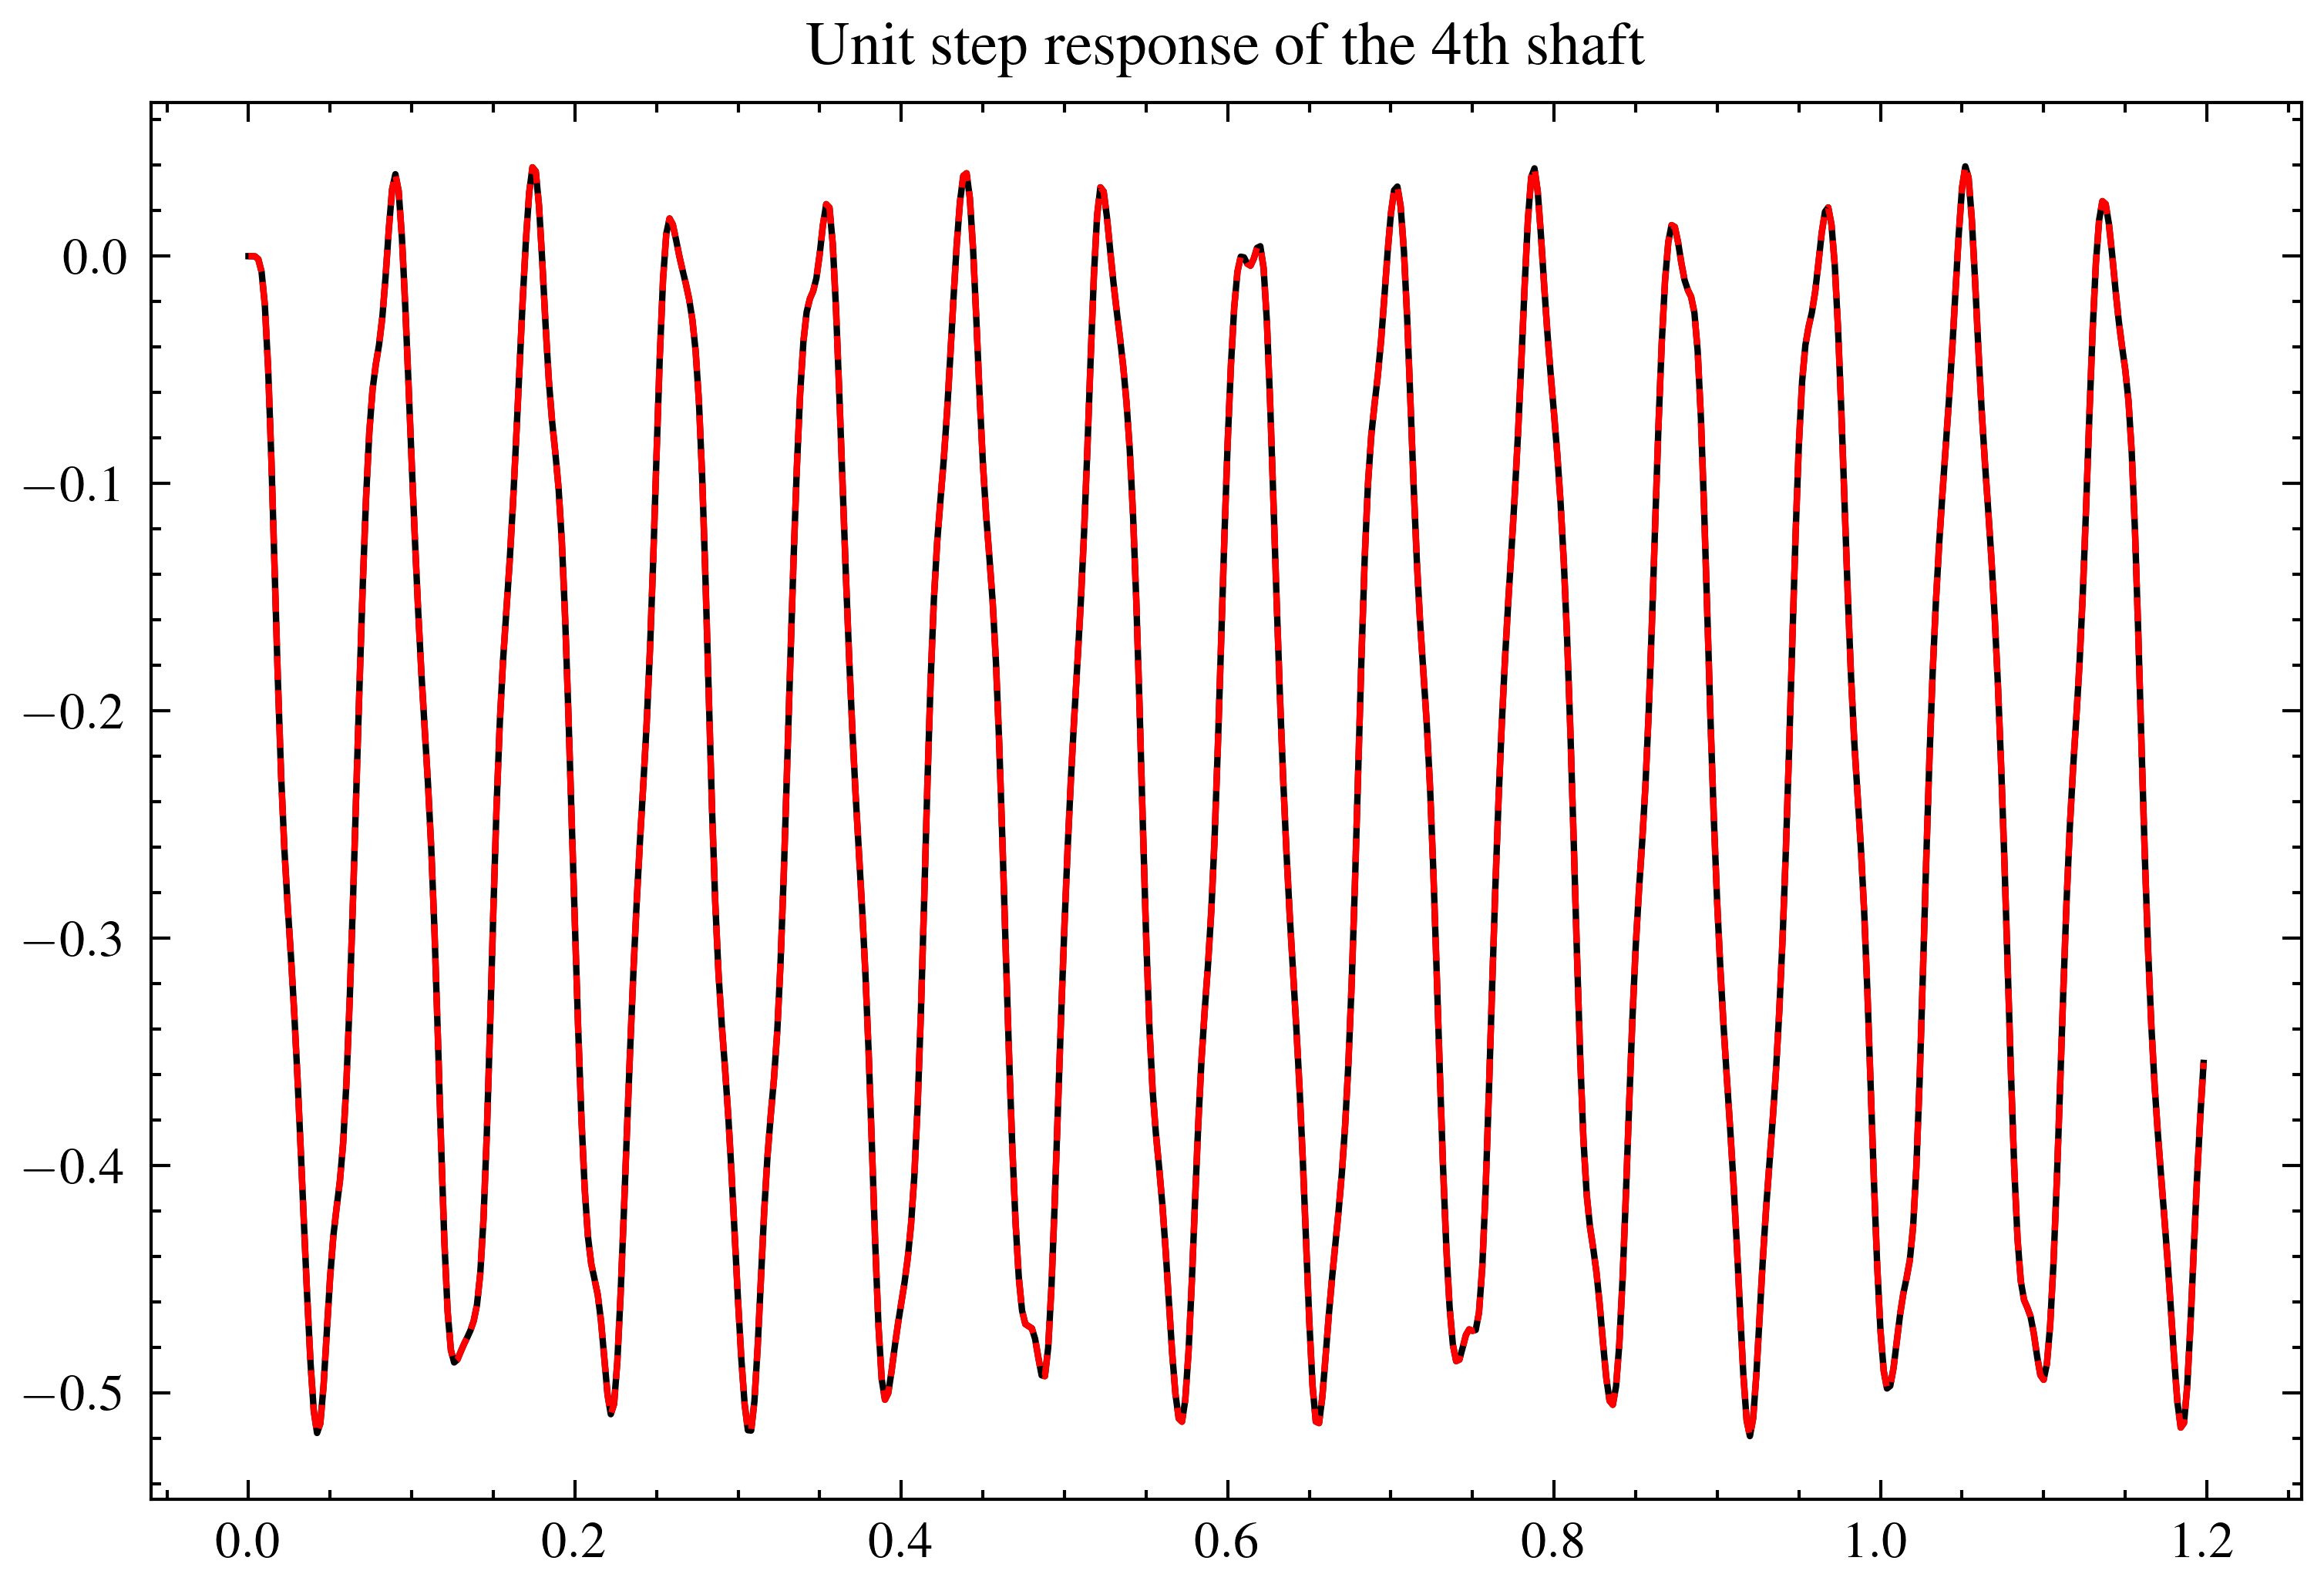

In [12]:
# In Ikonen et al., the simulation is defined to be 1.2 seconds with a step of 2 ms.
t = np.arange(0, 1.200, 0.002)

# Impulse load applied at node 0.
u = np.zeros((len(t), 7))
u[:,0] = 1

tout, yout, xout = lsim((A, B, C, D), u, t)
tout_mod, yout_mod, xout_mod = lsim((A_transformed, B_transformed, C_transformed, D_transformed), u, t)

plt.plot(tout, 6.93e8*(yout[:,4] - yout[:,3]))
plt.plot(tout_mod, yout_mod[:,3], '--')
plt.title("Unit step response of the 4th shaft")
plt.show()

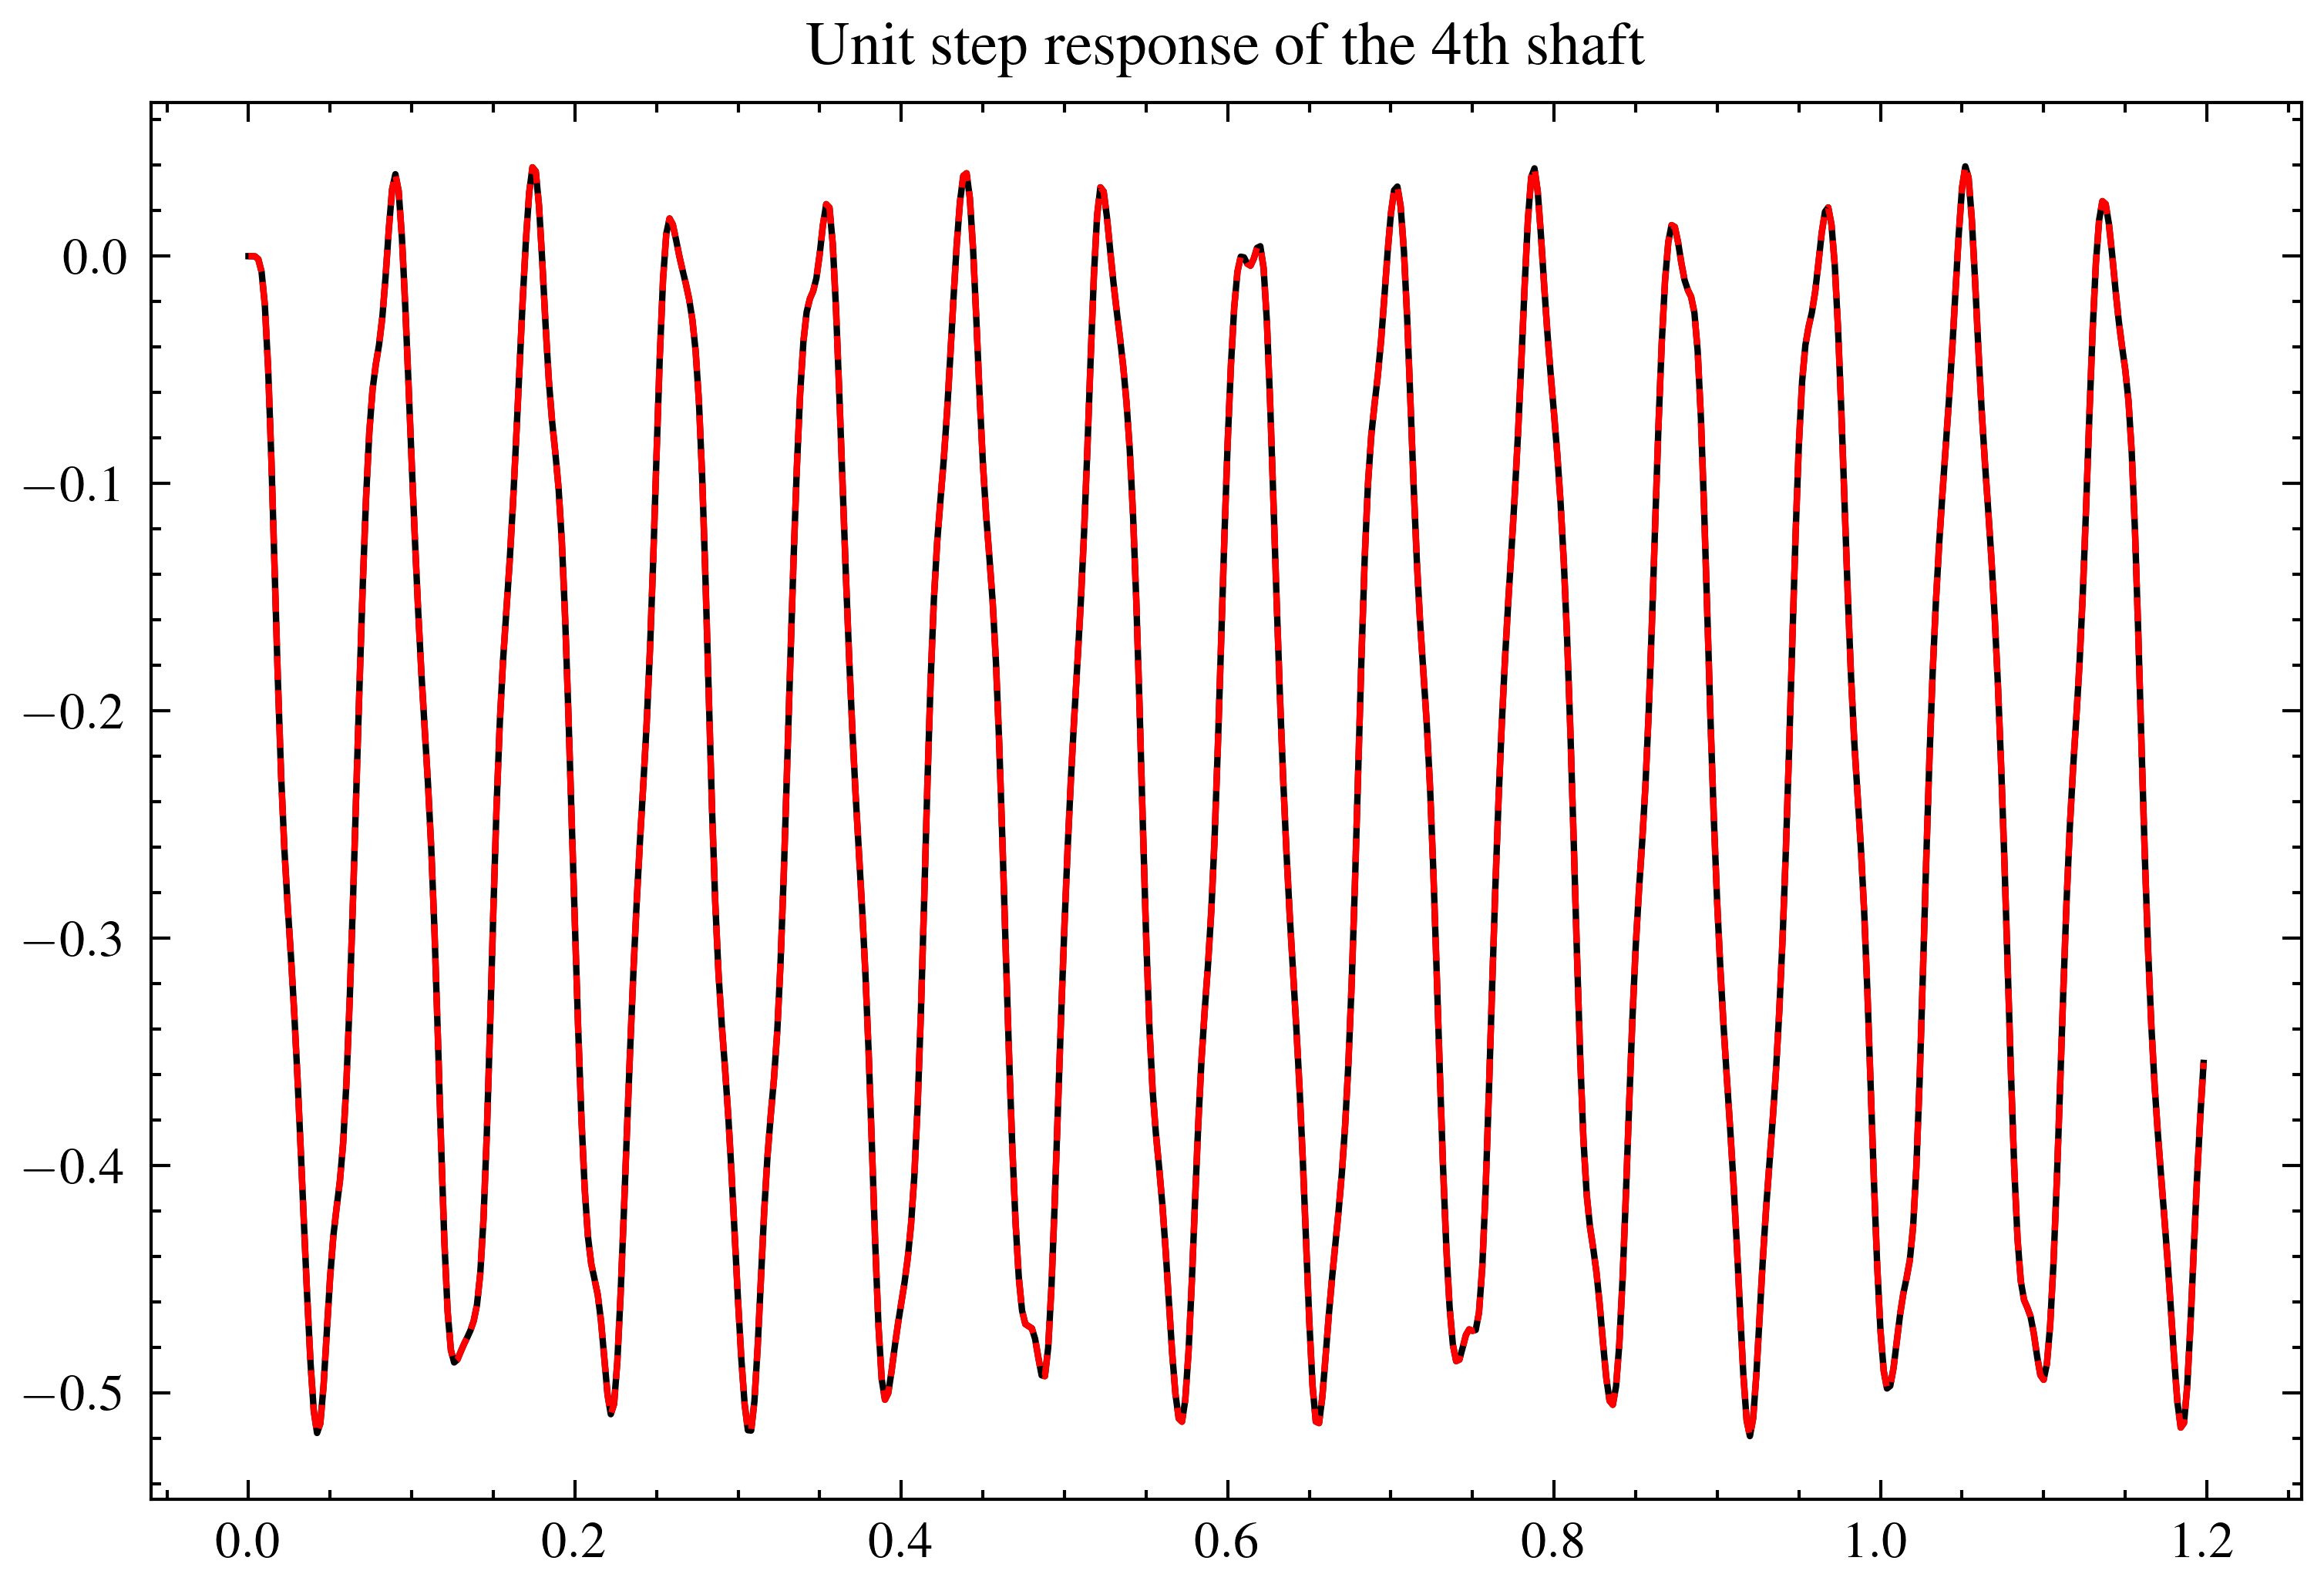

In [13]:
# discrete-time model
dt = np.mean(np.diff(t))

A_d, B_d = c2d(A, B, dt)
dtout, dyout, dxout = dlsim((A_d, B_d, C, D, dt), u, t=t)

A_transformed_d, B_transformed_d = c2d(A_transformed, B_transformed, dt)
dtout_mod, dyout_mod, dxout_mod = dlsim((A_transformed_d, B_transformed_d, C_transformed, D_transformed, dt), u, t=t)

plt.plot(dtout, 6.93e8*(dyout[:,4] - dyout[:,3]))
plt.plot(dtout_mod, dyout_mod[:,3], '--')
plt.title("Unit step response of the 4th shaft")
plt.show()

### Verify $\mathcal{O}$ and $\Gamma$ matrices

In [14]:
N = len(t)
B_t_d = np.array(B_transformed_d[:,0]).reshape(13,1)
extended_observation = O(A_transformed_d, C_transformed, N)
impulse_response = gamma(A_transformed_d, B_t_d, C_transformed, N)
print('Gamma matrix condition number', np.linalg.cond(impulse_response))

x0 = np.zeros((extended_observation.shape[1], 1))

# Impulse load applied at node 0.
U = np.ones((len(t), 1))

y_hat = extended_observation @ x0 + impulse_response @ U
meases = np.hstack(np.vsplit(y_hat, N))

Gamma matrix condition number inf


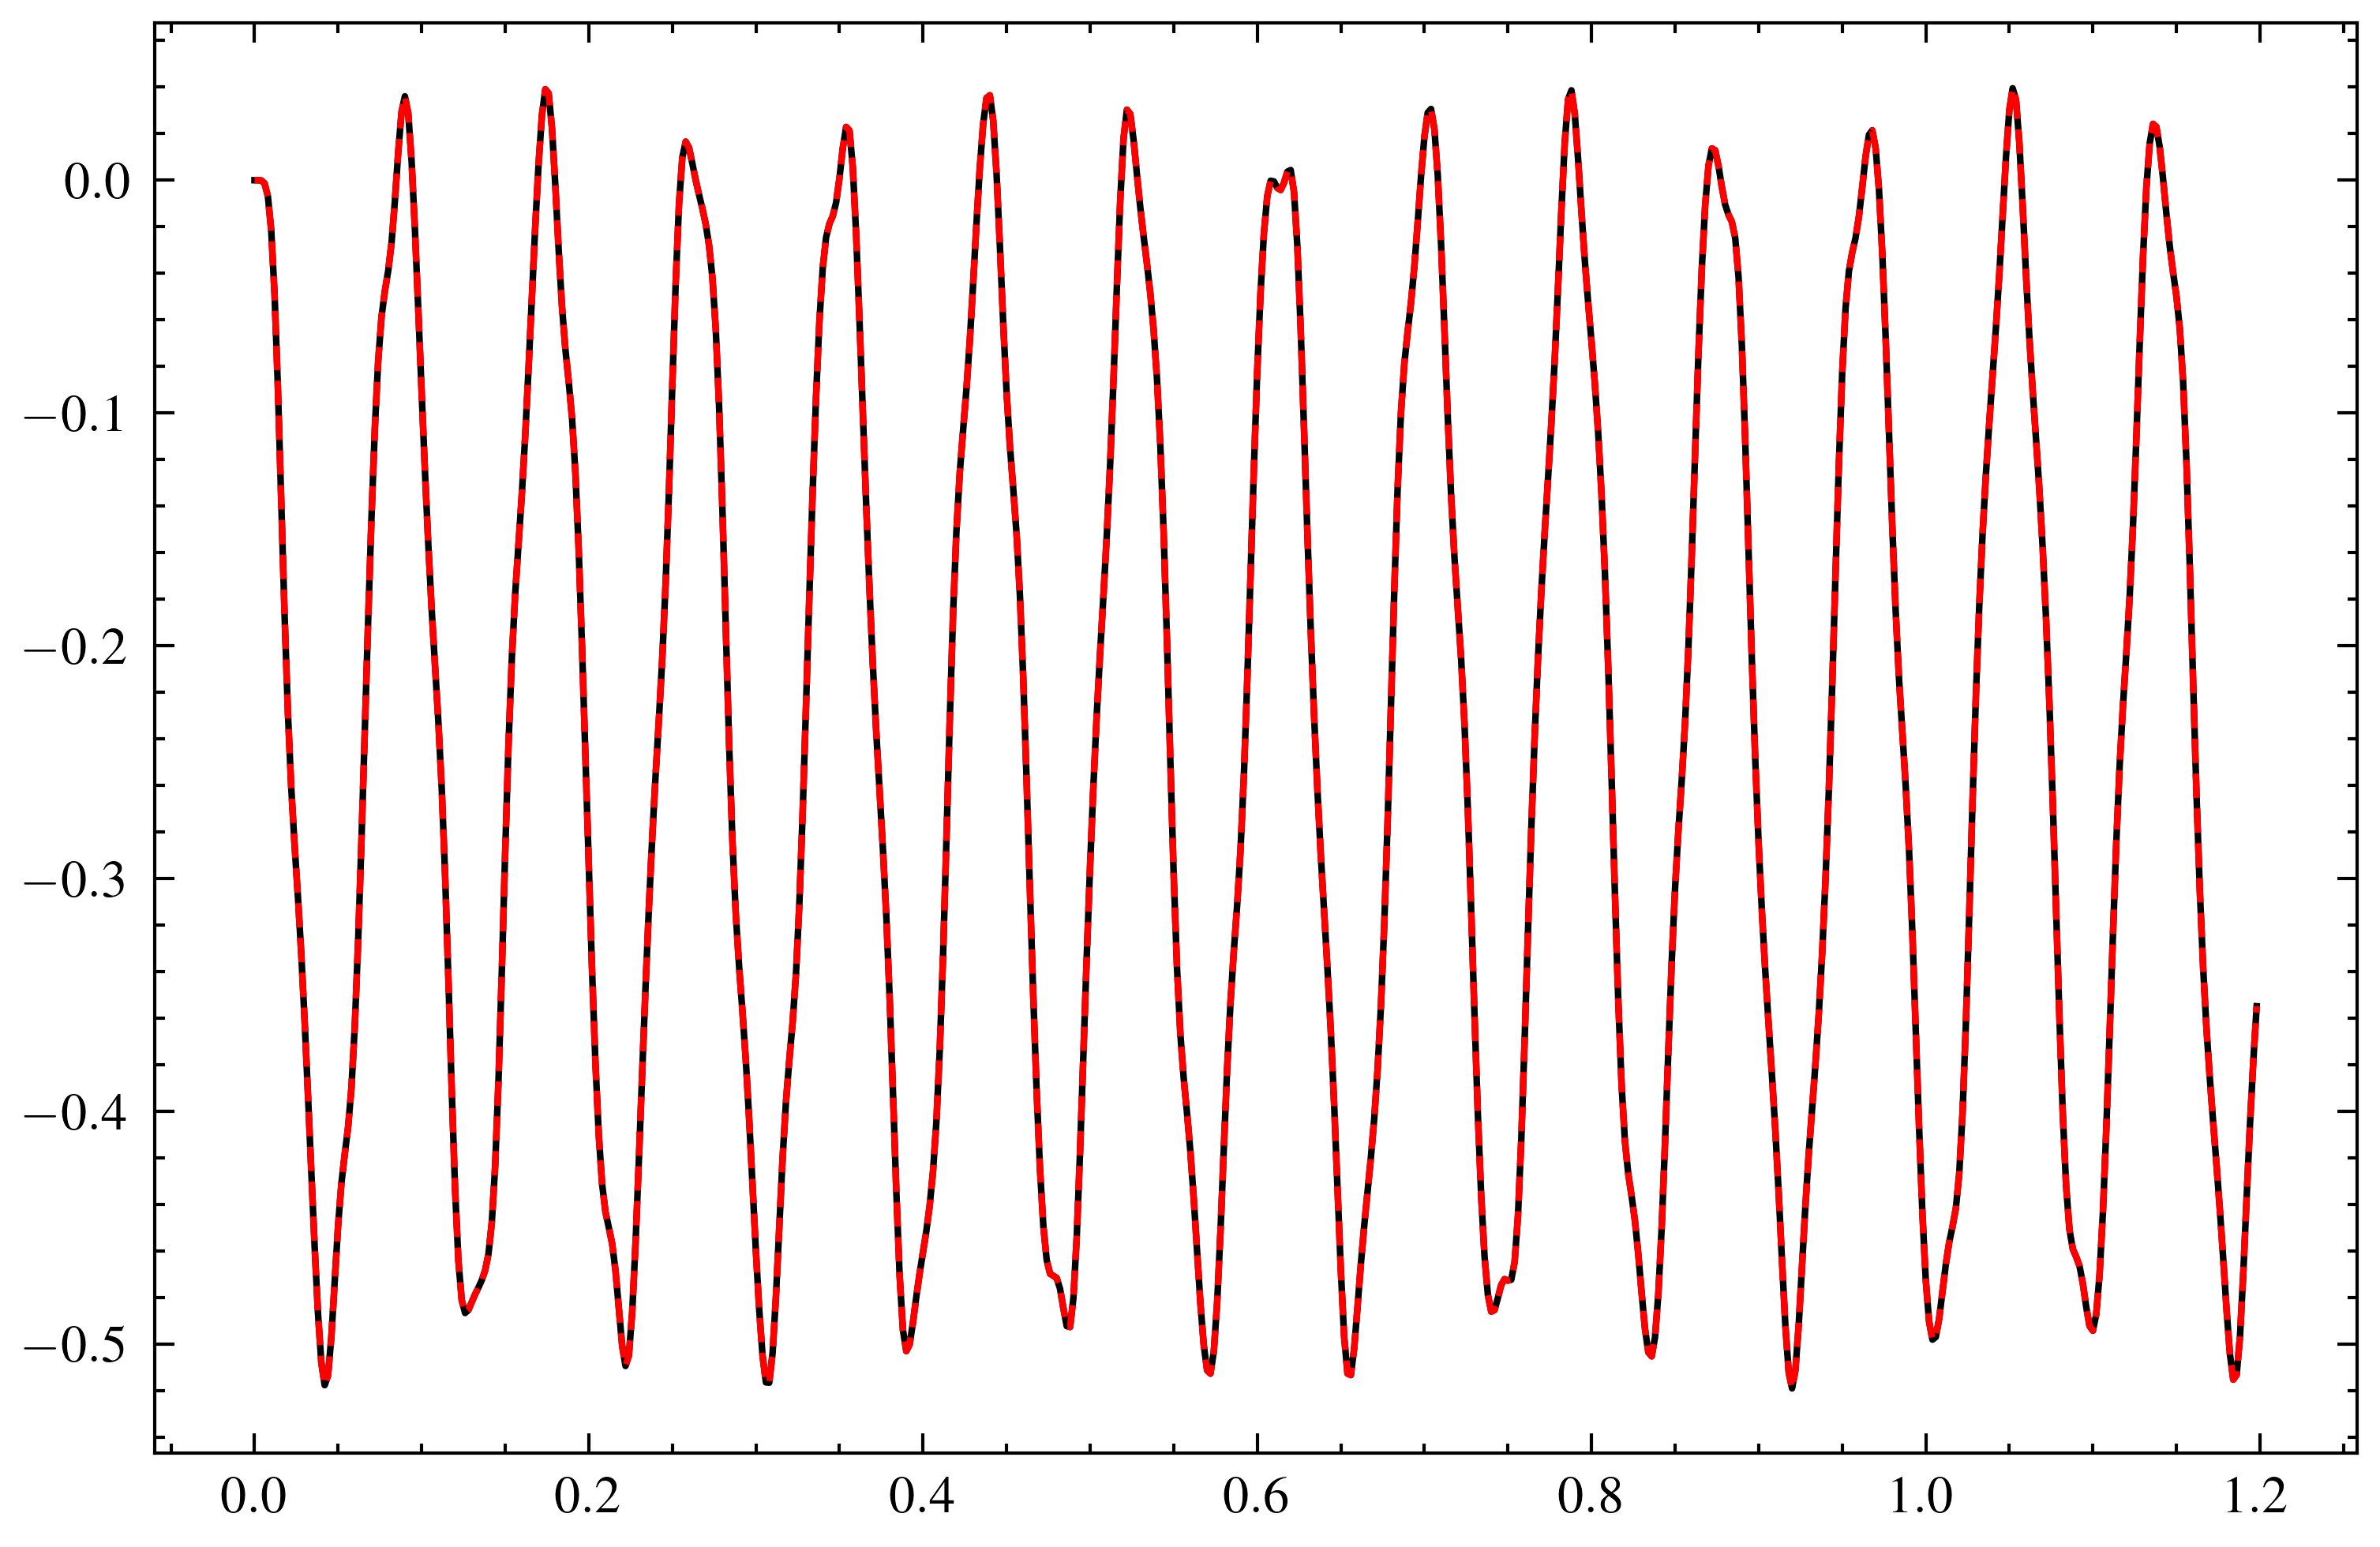

In [15]:
plt.plot(t, meases[3,:])
plt.plot(dtout_mod, dyout_mod[:,3])
plt.show()

### Generating measurement data

To avoid inverse crime, in the paper of Ikonen et al., the propulsion system model defined above is modified by varying the inertia and stiffness values by $\pm 10$%. An additional damping coefficient for the propeller is also defined.

In [16]:
def propulsion_system_rand():
    J1 = np.random.uniform(0.9, 1.1)*1.347e4 # propeller
    J3 = np.random.uniform(0.9, 1.1)*5.590e2
    J5 = np.random.uniform(0.9, 1.1)*5.120e2
    J7 = np.random.uniform(0.9, 1.1)*4.870e2
    J9 = np.random.uniform(0.9, 1.1)*1.410e2
    J11 = np.random.uniform(0.9, 1.1)*1.740e2
    J13 = np.random.uniform(0.9, 1.1)*4.415e3 # motor
    
    k2 = np.random.uniform(0.9, 1.1)*5.88e7
    k4 = np.random.uniform(0.9, 1.1)*5.95e7
    k6 = np.random.uniform(0.9, 1.1)*1.12e8
    k8 = np.random.uniform(0.9, 1.1)*6.93e8
    k10 = np.random.uniform(0.9, 1.1)*5.09e8
    k12 = np.random.uniform(0.9, 1.1)*1.43e8
    
    damping = 180 # damping in steel_shafts
    propeller_damping = 120e3 # the propeller damping
    
    shafts, disks = [], []
    disks.append(ot.Disk(0, I=J1))
    shafts.append(ot.Shaft(0, 1, None, None, k=k2, I=0, c=propeller_damping+damping))
    disks.append(ot.Disk(1, I=J3))
    shafts.append(ot.Shaft(1, 2, None, None, k=k4, I=0, c=damping))
    disks.append(ot.Disk(2, I=J5))
    shafts.append(ot.Shaft(2, 3, None, None, k=k6, I=0, c=damping))
    disks.append(ot.Disk(3, I=J7))
    shafts.append(ot.Shaft(3, 4, None, None, k=k8, I=0, c=damping))
    disks.append(ot.Disk(4, I=J9))
    shafts.append(ot.Shaft(4, 5, None, None, k=k10, I=0, c=damping))
    disks.append(ot.Disk(5, I=J11))
    shafts.append(ot.Shaft(5, 6, None, None, k=k12, I=0, c=damping))
    disks.append(ot.Disk(6, I=J13))
    
    assembly = ot.Assembly(shafts, disk_elements=disks)
    _, f, _ = assembly.modal_analysis()
    print("Eigenfrequencies: ", f.round(2))

    return assembly, [k2, k4, k6, k8, k10, k12]

In [17]:
# Here the assembly is initialized again, as the component parameters are randomized.
# The system matrices are also constructed again.
assembly_rand, k_list_rand = propulsion_system_rand()
A_rand, B_rand = state_matrices(assembly_rand)
#B_rand = np.array(B_rand[:,-1])
C_rand, D_rand = np.eye(B_rand.shape[0]), np.zeros(B_rand.shape)

trans_rand = X(k_list_rand, ndof)
trans_inv_rand = trans_rand.T @ np.linalg.inv(trans_rand @ trans_rand.T)
A_mod_rand = trans_rand @ A_rand @ trans_inv_rand
B_mod_rand = trans_rand @ B_rand
C_mod_rand = np.eye(B_mod_rand.shape[0])
D_mod_rand = np.zeros(B_mod_rand.shape)

Eigenfrequencies:  [  0.     0.    11.32  11.32  48.35  48.35  73.47  73.47 109.93 109.93
 262.95 262.95 504.29 504.29]


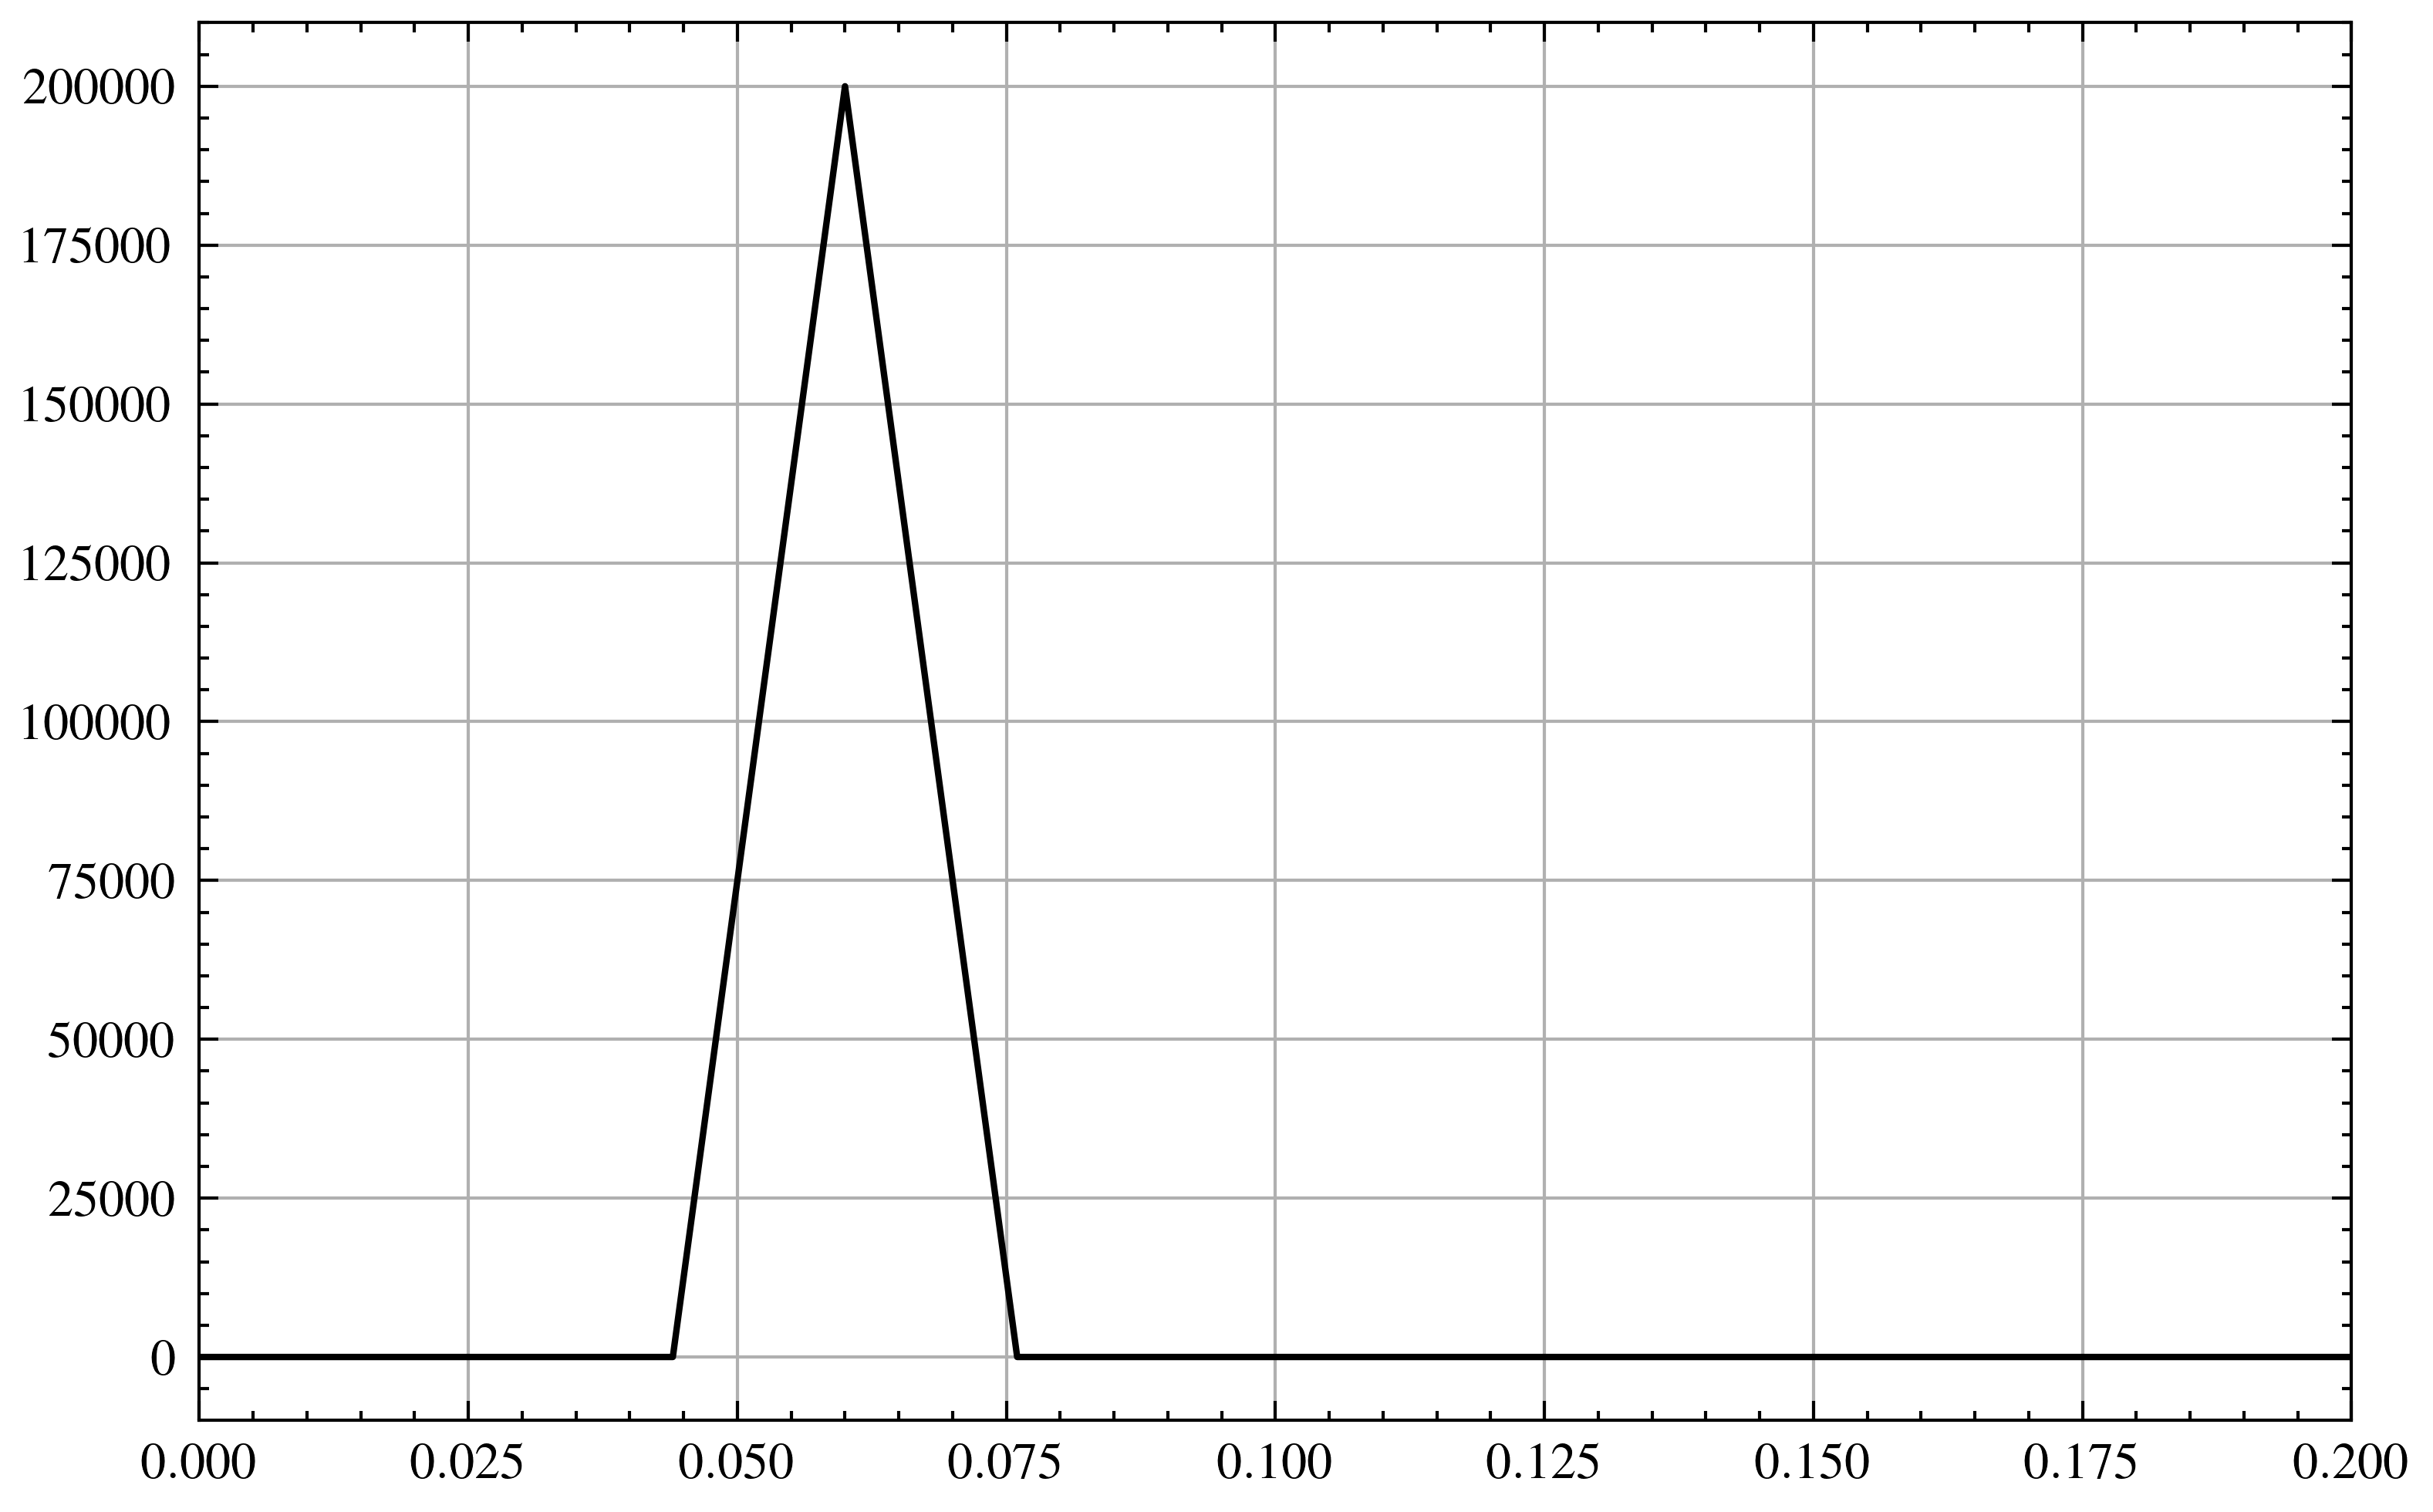

In [18]:
# An impulse load similar to the one described in Ikonen et al.
t = np.arange(0, 1.200, 0.002)

# impulse applied at node 0
impulse = np.zeros((len(t), 7))
ramp = np.arange(0, 200000, int(200000/8))
impulse[22:30,0] = ramp
impulse[30,0] = 200000
impulse[31:39,0] = ramp[::-1]

plt.plot(t, impulse[:,0])
plt.xlim(0,0.2)
plt.grid()
plt.show()

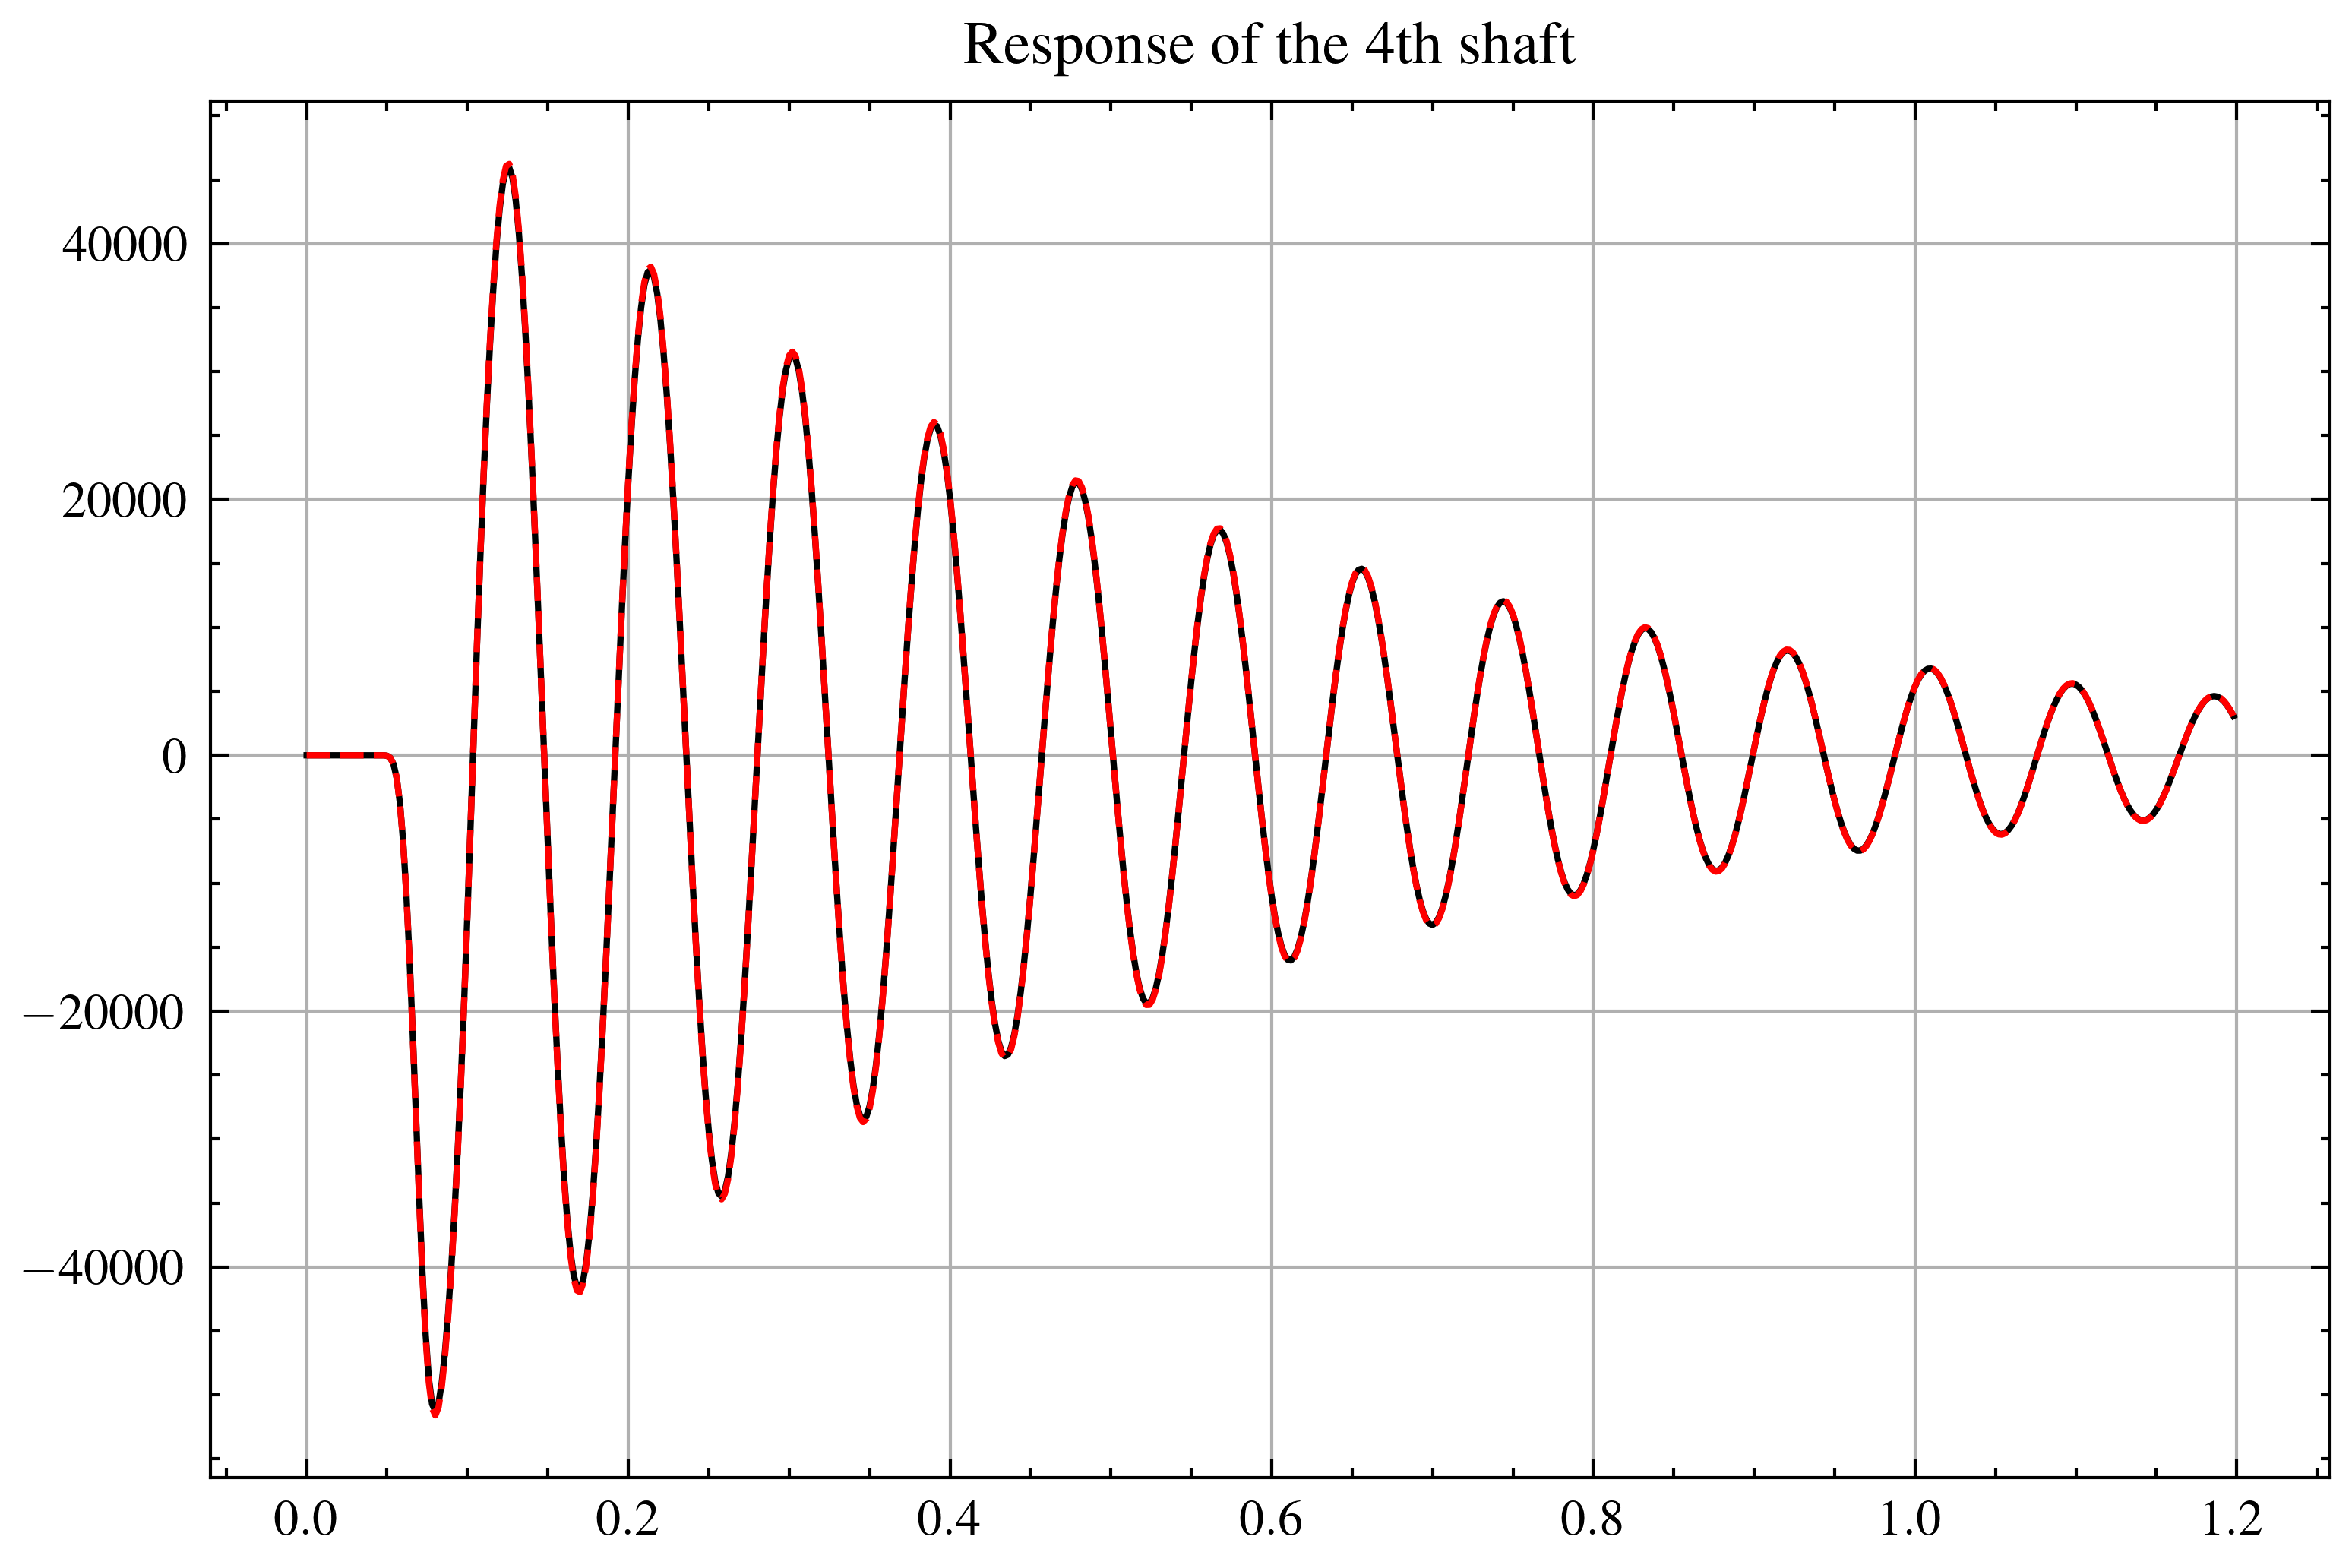

In [19]:
tout_rand, yout_rand, xout_rand = lsim((A_rand, B_rand, C_rand, D_rand), impulse, t)

tout_modded, yout_modded, xout_modded = lsim((A_mod_rand, B_mod_rand, C_mod_rand, D_mod_rand), impulse, t)

torque_meas_rand = k_list_rand[3]*(yout_rand[:,4]-yout_rand[:,3])

yout_modded_rand = np.random.uniform(0.98, 1.02)*yout_modded # Randomization of +-2% is added to the measurement.

plt.plot(tout_rand, torque_meas_rand)
plt.plot(tout_modded, yout_modded_rand[:,3], '--')
plt.grid()
plt.title("Response of the 4th shaft")
plt.show()

In [20]:
def construct_measurement(n, y):
    '''
    This function is used to construct a measurement vector used in the convex optimization
    problem so that for each timestep there is a vector containing one of each measurement.
    In this case, shaft torque of the 4th shaft and speed measurements from nodes 3 and 4
    are used (3 measurements per timestep in total). 
    '''
    measurement = np.vstack([y[0,0], y[0,1], y[0,2]])
    for i in range(1, n):
        measurement = np.vstack([measurement, y[i,0], y[i,1], y[i,2]])
    return measurement

In [21]:
def construct_measurement_full(n, y):
    '''
    This function is used to construct a measurement vector used in the convex optimization
    problem so that for each timestep there is a vector containing one of each measurement.
    In this case, all of the shaft torques and nodal speeds are used.
    '''
    measurement = y[0,:]
    for i in range(1, n):
        measurement = np.hstack([measurement, y[i,:]])

    return measurement.reshape(measurement.shape[0], 1)

The convex optimization problem is solved using batches of measurements of $n$ consecutive timesteps.

In [27]:
n = 600 # number of measurements in the batch
n_dof = 7 # number of degrees of freedom
estimates = np.zeros((n,1))

C_t_d = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # 

observer = O(A_transformed_d, C_t_d, n)
gam = gamma(A_transformed_d, B_t_d, C_t_d, n)

print('Gamma matrix condition number:', np.linalg.cond(gam))
reg = L(n) # size: number of nodes times number of timesteps

Gamma matrix condition number: inf


In [28]:
print(yout_modded_rand[:,3].shape)

(600,)


In [32]:
Y = yout_modded_rand[:,3].reshape(n,1)

estimate = convex_optimization_problem(Y, observer, gam, reg, lam=1e-20)

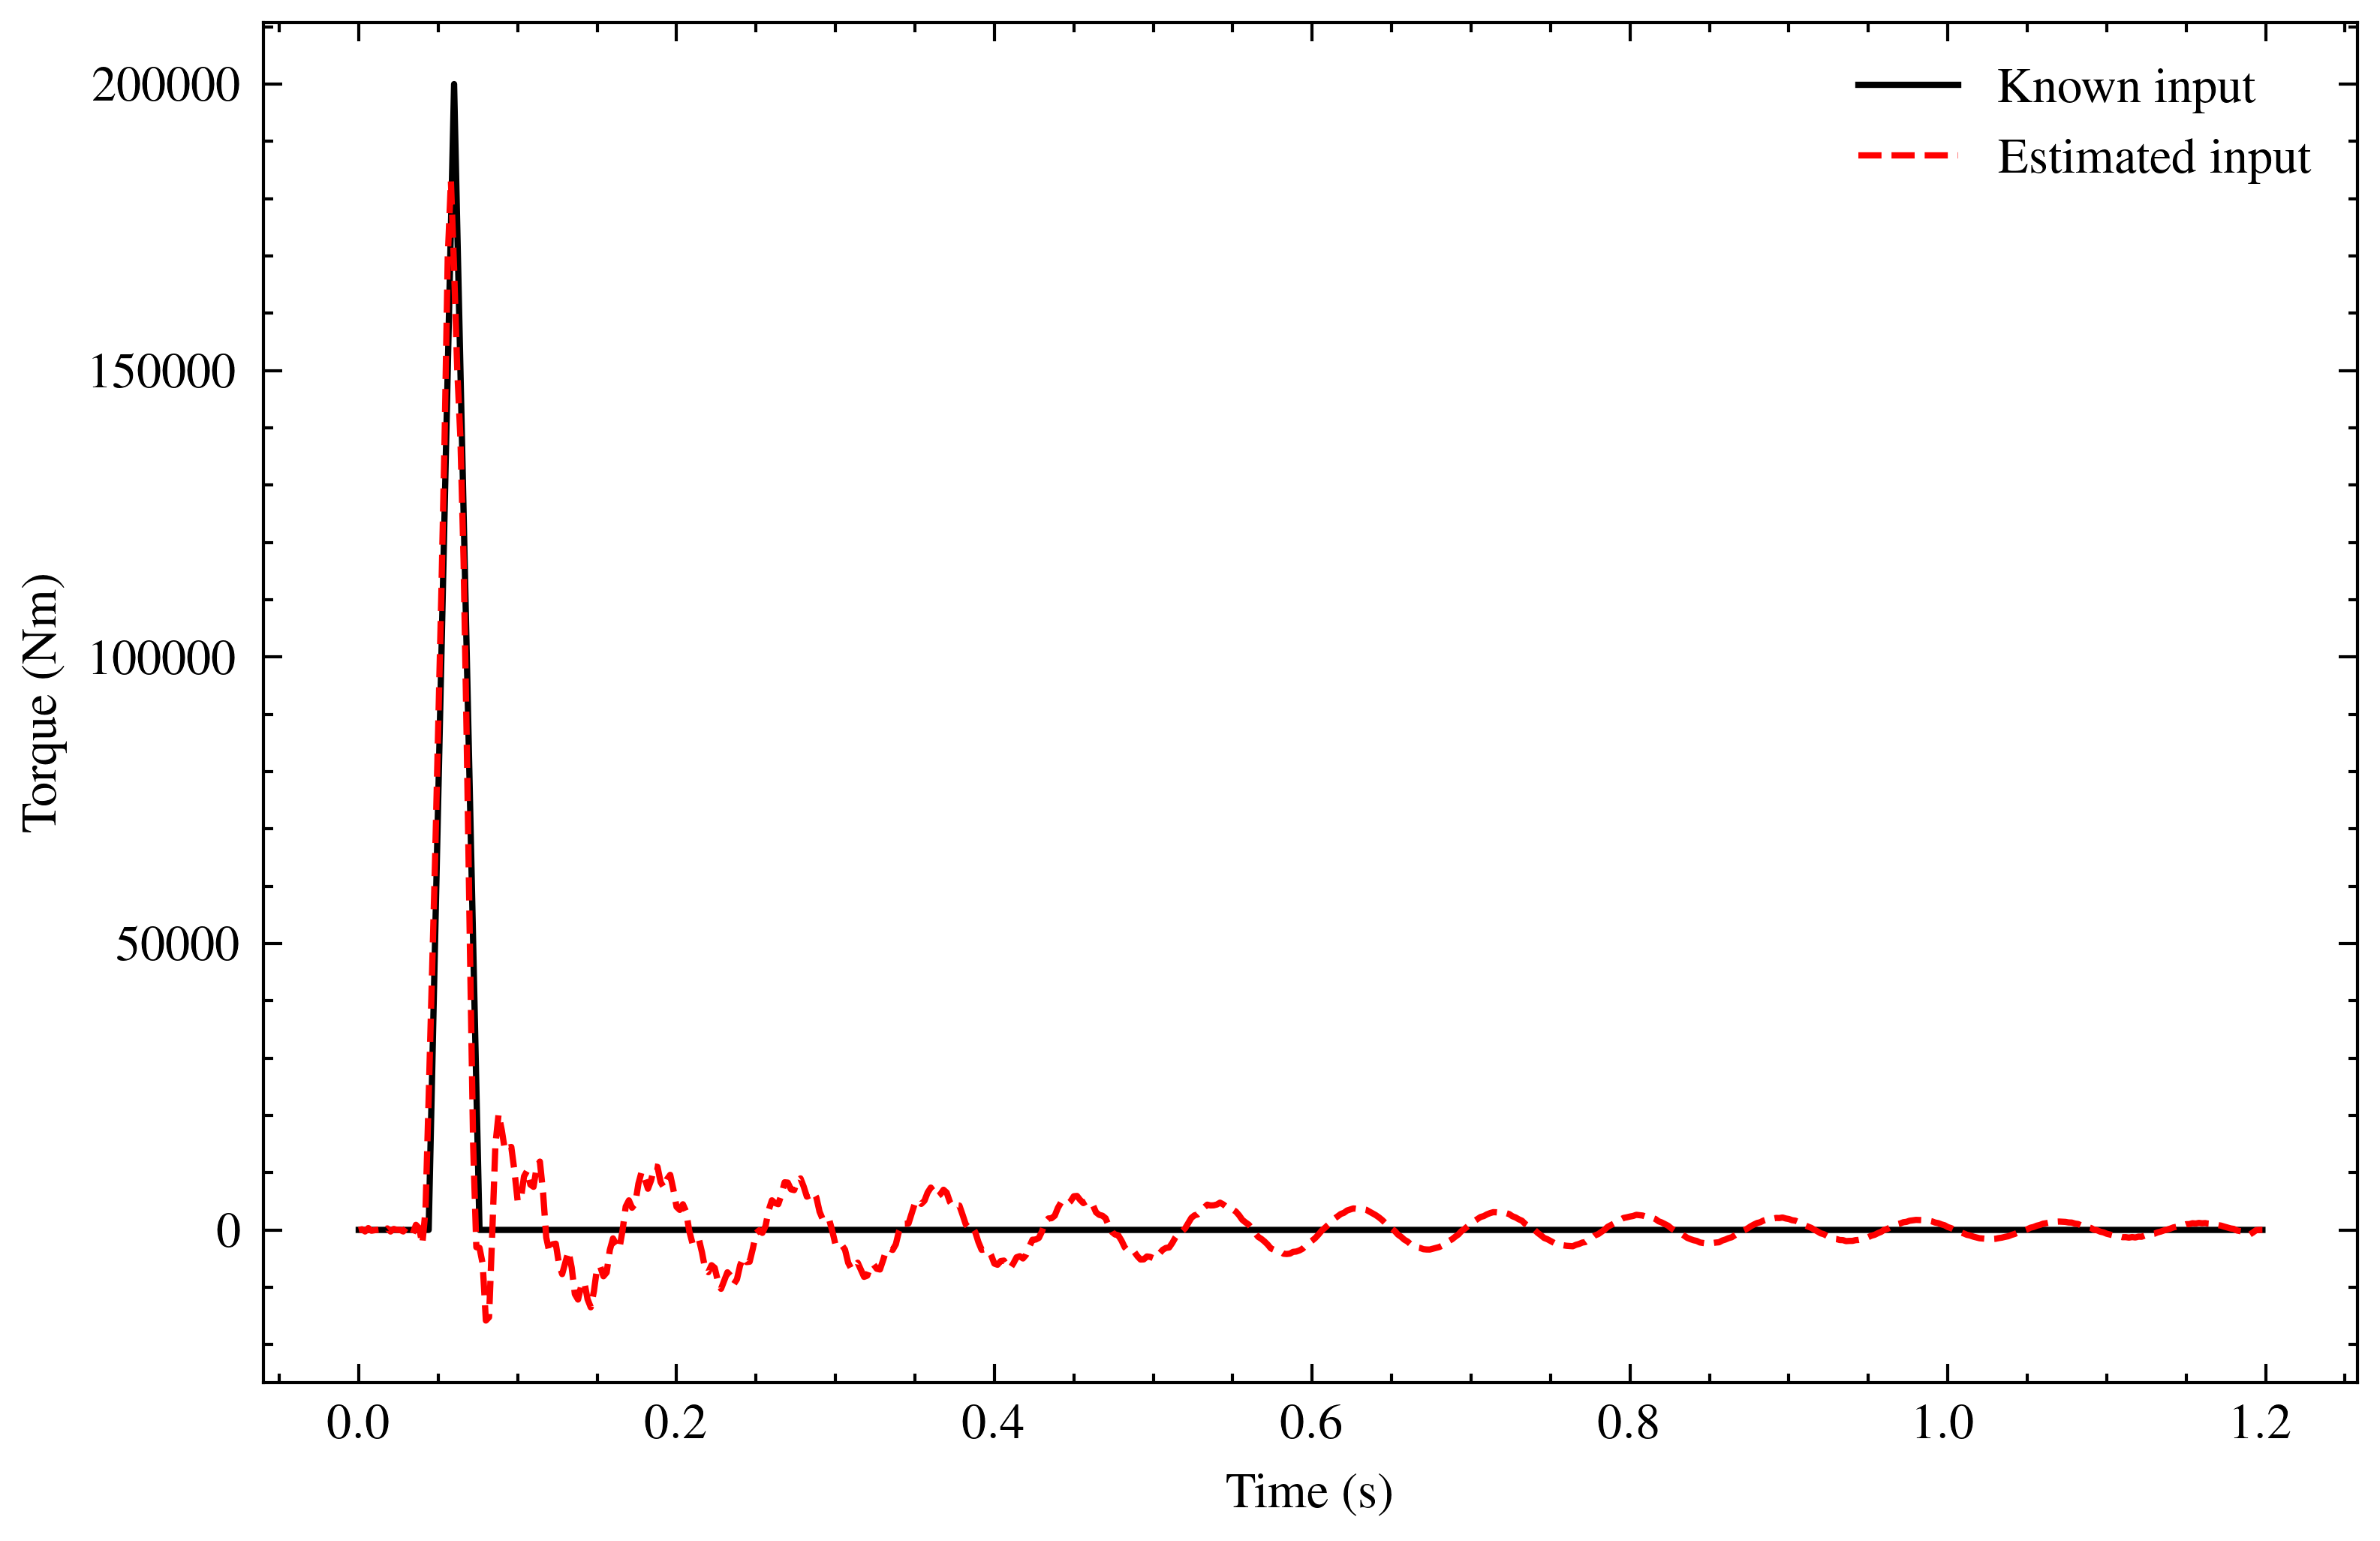

In [33]:
plt.plot(t, impulse[:,0], label='Known input')
plt.plot(t, estimate, label='Estimated input')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.show()